In [1]:
import torch
import torch.nn as nn

from torch import optim
from torch.autograd import Variable
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from utils.CvTransform import CvResize, CvCenterCrop

import torch.utils.data

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import ImgToSeq
from dataset.readVideo import DramaDataset
useCuda = True
Variable = Variable.cuda if useCuda else Variable

In [2]:
DataDir="/home/ball/Videos/BrokeEN"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=1,
                        )
transform = transforms.Compose([CvResize(256),
                                            CvCenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])
len(datasets)

Total Drama: 113


39494

In [3]:
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

In [4]:
def predit(modal, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = Variable(imgs.unsqueeze(0))
    subtitle = Variable(torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0))
    inputs = Variable(torch.LongTensor([[lang["SOS"]]]).long())
    hidden = None
    
    cxt = modal.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = modal.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        outputs = outputs[0][0].data[0]
        probs.append(prob[0][0].data[0])
        if(outputs == lang["EOS"]):
            break
        ans.append(outputs)
        inputs = Variable(torch.LongTensor([[outputs]]))
    return lang.vectorToSentence(ans), probs

def mutilePredit(pres, nexs, imgs):
    makes = []
    for pre, nex, img in zip(pres, nexs, imgs):
        mk = predit(modal, lang, transform(img[0]).unsqueeze(0), pre)
        makes.append(mk[0])
    return makes

def toBatchFirst(outputs):
    nep = len(outputs)
    nbatch = len(outputs[0])
    bFirst = []
    for b in range(nbatch):
        bdatas = []
        for e in range(nep):
            bdatas.append(outputs[e][b])
        bFirst.append(bdatas)
    return bFirst

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
toPIL = transforms.ToPILImage()

def showImgs(imgs, preSubs, targets, labels):
    col=1
    plt.figure(figsize=(20,50))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/col+1,col,i+1)
        plt.axis('off')
        plt.imshow(imgs[i])
        plt.title("Pre: {}\nNext: {}\nPredit: {}".format(preSubs[i], targets[i], labels[i]), fontsize=20)
    plt.show()
def showVar(data):
    x = range(0, data.size(-1))
    plt.bar(x, data.data.cpu())
    plt.show()
def showValue(data):
    x = range(0, len(data))
    plt.plot(x, data)
    plt.show()

In [6]:
import pickle
import os
ModelDir = "ImgSub2Sub/models/bkenS3nr"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
modal = torch.load(os.path.join(ModelDir, "SubImgModel.10.pth")).eval()

Load lang model: ImgSub2Sub/models/bkenS3nr. Word size: 15512


In [12]:
pres, nexs, imgs = getSample(64)

In [10]:
makes = mutilePredit(pres, nexs, imgs)
showImgs([ims[0] for ims in imgs], pres, nexs, makes)

TypeError: from_bounds() missing 2 required positional arguments: 'width' and 'height'

In [8]:
def getEncoder(modal, sub):
    subVar =  Variable(torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).unsqueeze(0))    
    return modal.subRnn(subVar)[0][:,-1,:]
cos = nn.CosineSimilarity(dim=1)

In [15]:
epcoss = []
outputs = []
for i in range(1, 11):
    modal = torch.load(os.path.join(ModelDir, "SubImgModel.{}.pth".format(i))).eval()
    makes = mutilePredit(pres, nexs, imgs)
    tars = torch.cat([getEncoder(modal, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(modal, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    epcoss.append(cs.mean().cpu().data[0])
    outputs.append(makes)
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}".format(cs.mean().cpu().data[0],
                                             cs.max().cpu().data[0],
                                             cs.min().cpu().data[0]))
bfOutputs = toBatchFirst(outputs)

Mean: 0.3112, Max: 0.7268, Min: 0.1953
Mean: 0.3328, Max: 0.5145, Min: 0.1884
Mean: 0.3478, Max: 1.0000, Min: 0.2205
Mean: 0.3370, Max: 0.5672, Min: 0.2040
Mean: 0.3506, Max: 1.0000, Min: 0.2143
Mean: 0.3441, Max: 1.0000, Min: 0.2057
Mean: 0.3692, Max: 1.0000, Min: 0.2150
Mean: 0.3577, Max: 1.0000, Min: 0.2015
Mean: 0.3745, Max: 1.0000, Min: 0.1701
Mean: 0.3840, Max: 1.0000, Min: 0.2268


In [16]:
coss = []
for makes in outputs:
    tars = torch.cat([getEncoder(modal, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(modal, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    coss.append(cs.mean().cpu().data[0])
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}, Equal: {}".format(cs.mean().cpu().data[0],
                                                         cs.max().cpu().data[0],
                                                         cs.min().cpu().data[0],
                                                         (cs>=0.9).float().sum().cpu().data[0]))

Mean: 0.2892, Max: 0.6274, Min: 0.1976, Equal: 0.0
Mean: 0.3111, Max: 0.4655, Min: 0.1866, Equal: 0.0
Mean: 0.3293, Max: 1.0000, Min: 0.2070, Equal: 1.0
Mean: 0.3246, Max: 0.5213, Min: 0.2006, Equal: 0.0
Mean: 0.3421, Max: 1.0000, Min: 0.2006, Equal: 1.0
Mean: 0.3378, Max: 1.0000, Min: 0.2006, Equal: 1.0
Mean: 0.3642, Max: 1.0000, Min: 0.1995, Equal: 1.0
Mean: 0.3530, Max: 1.0000, Min: 0.2041, Equal: 2.0
Mean: 0.3749, Max: 1.0000, Min: 0.1724, Equal: 2.0
Mean: 0.3840, Max: 1.0000, Min: 0.2268, Equal: 3.0


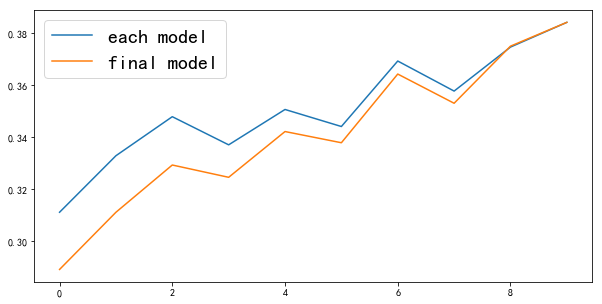

In [17]:
x = range(0, len(coss))
plt.figure(figsize=(10,5))
plt.plot(x, epcoss, label="each model")
plt.plot(x, coss, label="final model")

plt.legend(fontsize=20)
plt.show()

In [20]:
import torch.nn.functional as F
efa = F.relu(modal.subRnn.embedding(Variable(torch.LongTensor([lang["we"]]))))
efb = F.relu(modal.subRnn.embedding(Variable(torch.LongTensor([lang["they"]]))))
cos(efb, efa).mean().cpu().data[0]

0.28146180510520935

In [48]:
tars = torch.cat([getEncoder(modal, "Han")], dim=0)
preds = torch.cat([getEncoder(modal, "Max")], dim=0)
cos(tars, preds).mean().cpu().data[0]

0.35199084877967834

Pre: Caroline rumor has it you
Next: let one fly in yoga class

Oh my God
Oh no no no no no no
Oh my God Oh no
Oh my God Max
Oh my God Max hurry
A little too cupcake window
A little too cupcake window in a dumpster
A little too cupcake window
A little too cupcake window in a dumpster
A little too cupcake window


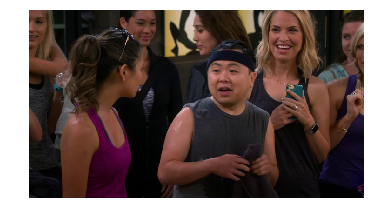

In [72]:
i = 21
print("Pre: {}".format(pres[i]))
print("Next: {}\n".format(nexs[i]))
print("\n".join(bfOutputs[i]))
plt.axis('off')
plt.imshow(imgs[i][0])
plt.show()